In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller as ADF
import numpy as np
import torch
from Model import ARIMA_LSTM
from data import ARIMA_LSTM_dataset
from train import train
from torch.utils.data import DataLoader

c:\ProgramData\Anaconda3\envs\pytorch_train\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


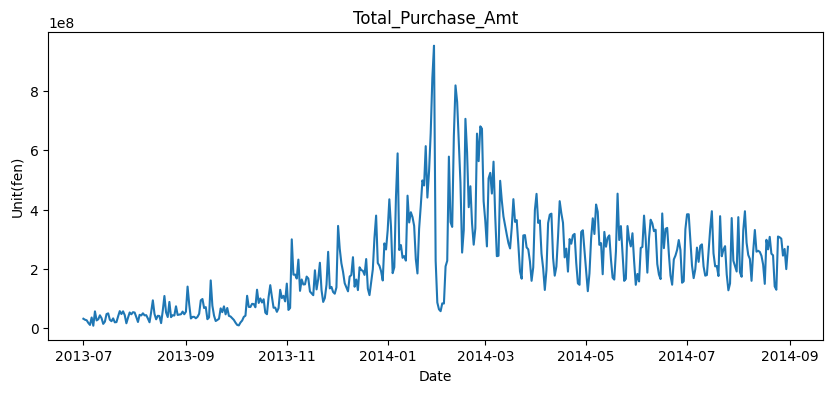

In [2]:
#数据预处理
user_balance = pd.read_csv('C:/Users/Administrator/Desktop/科研/github/Data/Purchase Redemption Data/user_balance_table.csv')

#以日期为索引，对每个日期的申购和赎回金额进行求和
df_temp = user_balance.groupby(['report_date'])['total_purchase_amt','total_redeem_amt'].sum()

#重新生成索引
df_temp.reset_index(inplace=True)

#修改日期格式，方便对日期进行选择和切片
df_temp['report_date'] = pd.to_datetime(df_temp['report_date'],format='%Y%m%d')
df_temp.index = df_temp['report_date']

total_purchase_amt = plt.figure(figsize=(10,4))
ax = total_purchase_amt.add_subplot(111)
ax.set(title='Total_Purchase_Amt',ylabel='Unit(fen)', xlabel='Date')
plt.plot(df_temp['report_date'],df_temp['total_purchase_amt'])
plt.show()

In [3]:
#选择2014年4月起始的数据
#训练数据集123天
#测试数据集30天
def generate_purchase_seq():
    dateparse = lambda dates:pd.datetime.strptime(dates,'%Y%m%d')
    user_balance = pd.read_csv('C:/Users/Administrator/Desktop/科研/github/Data/Purchase Redemption Data/user_balance_table.csv',parse_dates=['report_date'],index_col=['report_date'],date_parser=dateparse)

    df = user_balance.groupby(['report_date'])['total_purchase_amt'].sum()
    #转成序列
    purchase_seq = pd.Series(df,name='value')

    #切分出训练集和测试集
    purchase_seq_train = purchase_seq['2014-04-01':'2014-08-01']
    purchase_seq_test = purchase_seq['2014-08-02':'2014-08-31']

    purchase_seq_train.to_csv('./total_purchase_train.csv',header=True)
    purchase_seq_test.to_csv('./total_purchase_test.csv',header=True)

generate_purchase_seq()

c:\ProgramData\Anaconda3\envs\pytorch_train\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """


In [4]:
dateparse = lambda dates:pd.datetime.strptime(dates,'%Y-%m-%d')
purchase_seq_train = pd.read_csv('./total_purchase_train.csv',parse_dates=['report_date'],index_col=['report_date'],date_parser=dateparse)
real_mean = np.mean(purchase_seq_train)
real_std = np.std(purchase_seq_train)
real_std = real_std.to_numpy()
real_mean = real_mean.to_numpy()
purchase_seq_train= (purchase_seq_train - np.mean(purchase_seq_train))/np.std(purchase_seq_train)

c:\ProgramData\Anaconda3\envs\pytorch_train\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


In [5]:
#对数据进行平稳性检验
def diff(timeseries):
    timeseries_diff1 = timeseries.diff(1)
    timeseries_diff2 = timeseries_diff1.diff(1)

    timeseries_diff1 = timeseries_diff1.fillna(0)
    timeseries_diff2 = timeseries_diff2.fillna(0)

    timeseries_adf = ADF(timeseries)
    timeseries_diff1_adf = ADF(timeseries_diff1)
    timeseries_diff2_adf = ADF(timeseries_diff2)

    print('timeseries_adf : ', timeseries_adf)
    print('timeseries_diff1_adf : ', timeseries_diff1_adf)
    print('timeseries_diff2_adf : ', timeseries_diff2_adf)

    plt.figure(figsize=(12,8))
    plt.plot(timeseries,label='Original',color='blue')
    plt.plot(timeseries_diff1,label='diff1',color='red')
    plt.plot(timeseries_diff2,label='diff2',color='purple')
    plt.legend(loc='best')
    plt.show()

In [6]:
#ACF指标与PACF指标
def autocorrelation(timeseries, lags):
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    sm.graphics.tsa.plot_acf(timeseries, lags=lags, ax=ax1)
    ax2 = fig.add_subplot(212)
    sm.graphics.tsa.plot_pacf(timeseries, lags=lags, ax=ax2)
    plt.show()

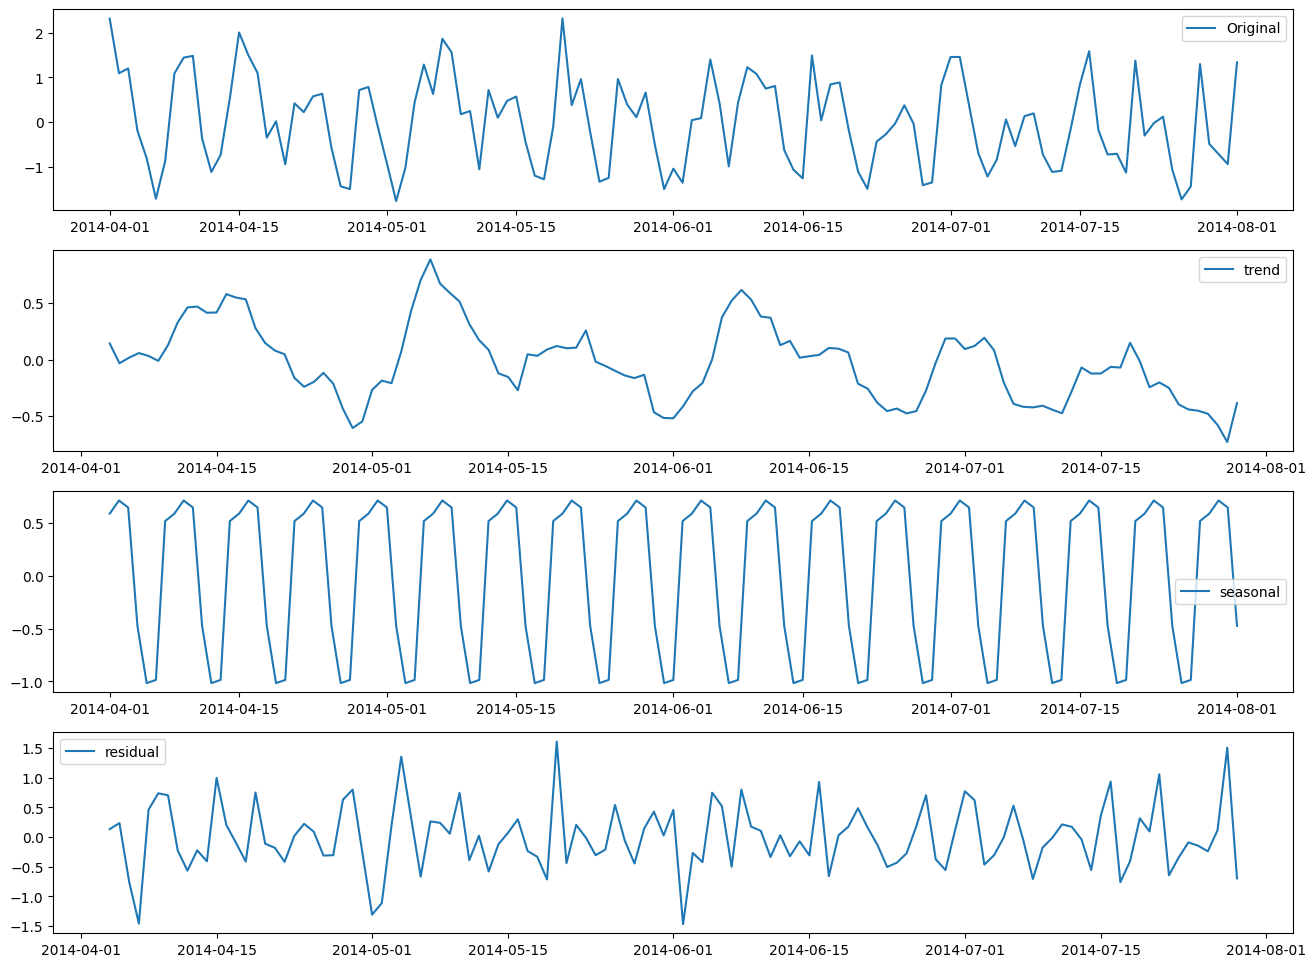

In [7]:
#对数据进行季节分量的加性分解
#观察周期长度
def decomposing(timeseries):
    decomposition = seasonal_decompose(timeseries)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.figure(figsize=(16,12))
    plt.subplot(411)
    plt.plot(timeseries,label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend,label='trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='seasonal')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual,label='residual')
    plt.legend(loc='best')
    plt.show()


decomposing(purchase_seq_train)

timeseries_adf :  (-2.9219585053059336, 0.04285346156030011, 8, 114, {'1%': -3.489057523907491, '5%': -2.887246327182993, '10%': -2.5804808802708528}, -150.26576438259985)
timeseries_diff1_adf :  (-5.2643498573565, 6.487754327657025e-06, 13, 109, {'1%': -3.49181775886872, '5%': -2.8884437992971588, '10%': -2.5811201893779985}, -144.9404412244121)
timeseries_diff2_adf :  (-6.360313180635243, 2.4838153611909038e-08, 9, 113, {'1%': -3.489589552580676, '5%': -2.887477210140433, '10%': -2.580604145195395}, -122.10448164972055)


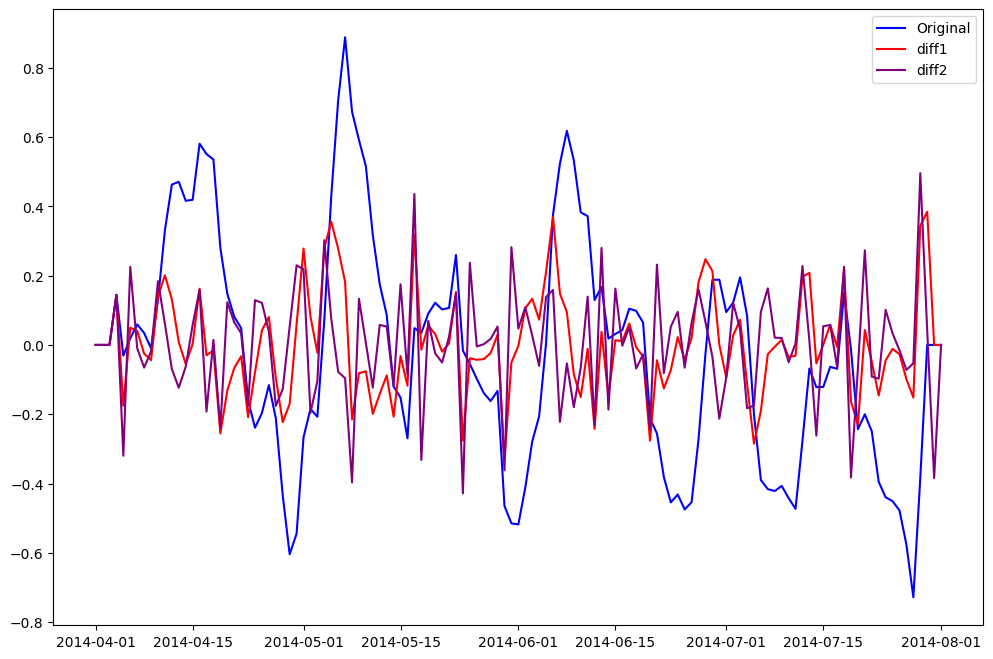

timeseries_adf :  (-6.675200782082556, 4.483399339523369e-09, 8, 114, {'1%': -3.489057523907491, '5%': -2.887246327182993, '10%': -2.5804808802708528}, 147.5609729598121)
timeseries_diff1_adf :  (-6.140919434134555, 7.97527190975268e-08, 13, 109, {'1%': -3.49181775886872, '5%': -2.8884437992971588, '10%': -2.5811201893779985}, 176.37174308579742)
timeseries_diff2_adf :  (-6.794302311375007, 2.3219561093693e-09, 13, 109, {'1%': -3.49181775886872, '5%': -2.8884437992971588, '10%': -2.5811201893779985}, 208.17640242679997)


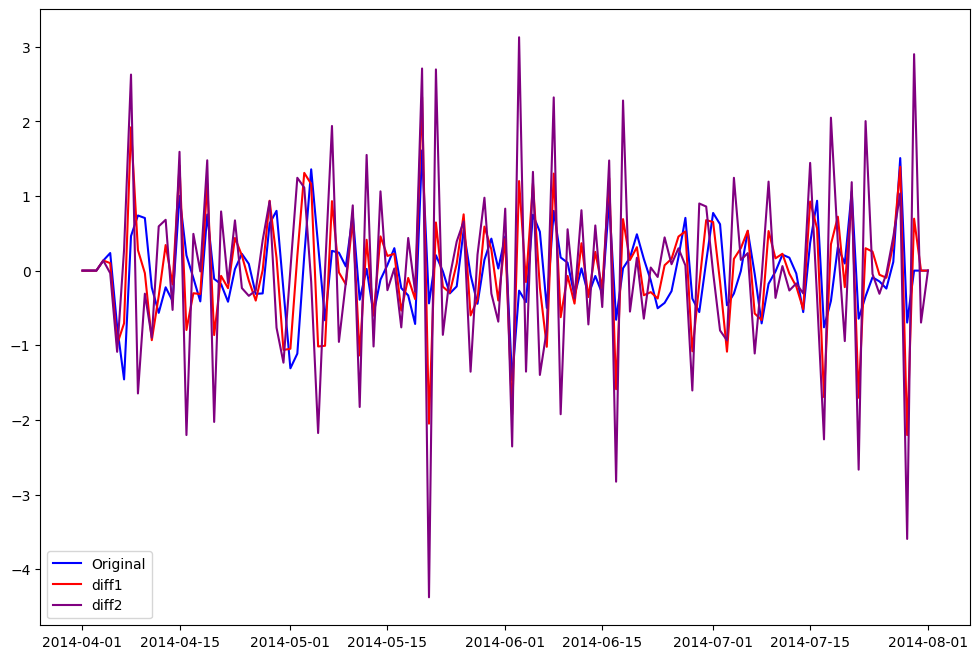

In [8]:
#由上图可以看出，周期为7或者14天
#对趋势分量和残差分量进行平稳性检验
decomposition = seasonal_decompose(purchase_seq_train)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

trend = trend.fillna(0)
seasonal = seasonal.fillna(0)
residual = residual.fillna(0)

diff(trend)
diff(residual)

#转成tensor
trend = torch.tensor(trend).unsqueeze(dim=1)
seasonal = torch.tensor(seasonal).unsqueeze(dim=1)
residual = torch.tensor(residual).unsqueeze(dim=1)

c:\ProgramData\Anaconda3\envs\pytorch_train\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


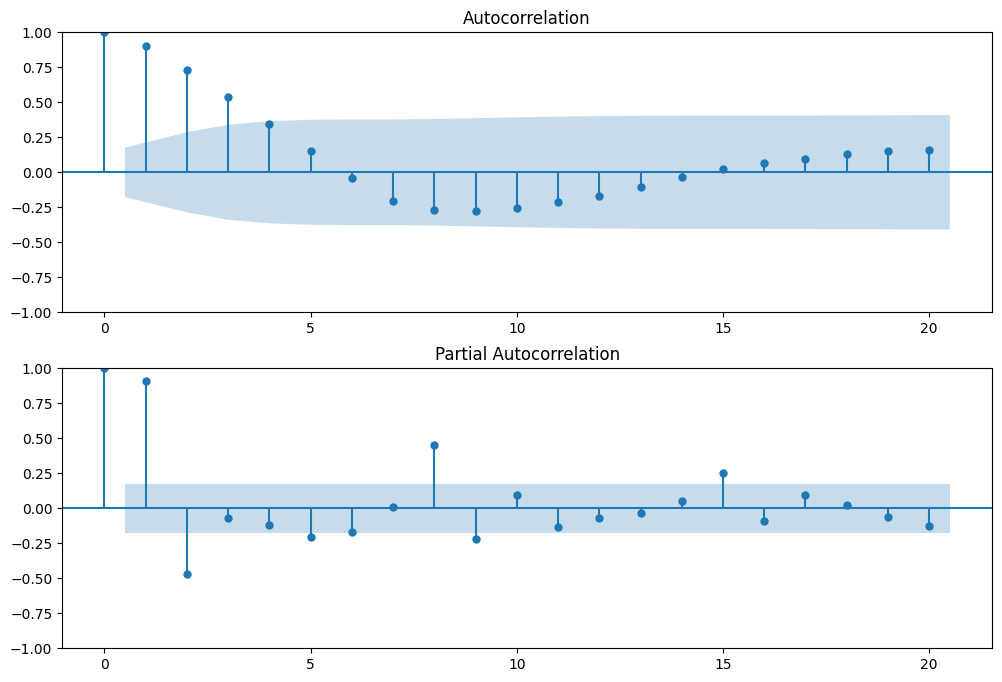

c:\ProgramData\Anaconda3\envs\pytorch_train\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


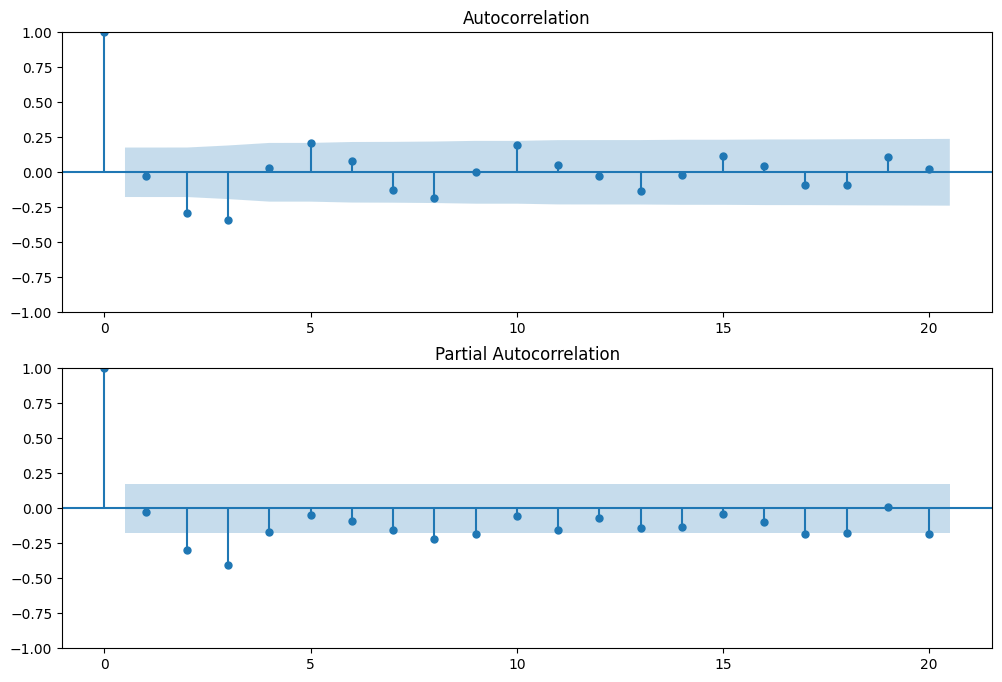

In [9]:
#由上图可以看出，数据本身平稳性良好，不需要进行差分
#现在根据季节分量周期长度、趋势序列、残差序列的PACF、ACF指标决定马尔科夫链（取5者中最大的）
autocorrelation(trend,20)
autocorrelation(residual,20)

In [10]:
#由上图可以看出
#趋势序列，ACF值在第4项后出现截尾，PACF在第2项后出现拖尾
#残差序列，ACF值在第3项之出现拖尾，PACF在第3项之后出现截尾
#因此我们选择，趋势序列 p = 1, q = 2
#残差序列 p = 3, q = 3
#结合季节分量的周期长度，我们选择马尔科夫链的长度为7
time_range = pd.date_range('2014-04-01','2014-08-01',freq='D')
covariate_df = pd.DataFrame(index=time_range,
                            data={'dayofweek':time_range.dayofweek,
                                 'month': time_range.month
                                })
#日历数据（协变量）归一化
for col in covariate_df.columns:
    covariate_df[col] = (covariate_df[col] - np.mean(covariate_df[col]))/np.std(covariate_df[col])
    

In [11]:
#将三个数据concat起来
covariate_df = torch.tensor(covariate_df.to_numpy())
input_series = torch.concat([trend,residual,covariate_df],dim=1)

In [44]:
#导入模型
config = {
    'horizon_size':1,
    'hidden_size':32,#8
    'dropout': 1e-1,
    'layer_size':2,
    'lr': 1e-4,#5
    'batch_size': 30,
    'num_epochs':1000,
    'input_size':4,
    'output_size':1,
    'seq_len':7
}
horizon_size = config['horizon_size']
input_size = config['input_size']
output_size = config['output_size']
hidden_size = config['hidden_size']
dropout = config['dropout']
layer_size = config['layer_size']
seq_len = config['seq_len']
lr = config['lr']
batch_size = config['batch_size']
num_epochs = config['num_epochs']

myseed = 6666  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dataset = ARIMA_LSTM_dataset(input_series,seasonal,horizon_size,seq_len)
model = ARIMA_LSTM(horizon_size,input_size,output_size,hidden_size,dropout,layer_size,device)

epoch_num 5, current loss is: 0.13094774128636003
epoch_num 10, current loss is: 0.14155749480067317
epoch_num 15, current loss is: 0.098425436976
epoch_num 20, current loss is: 0.13118807203898247
epoch_num 25, current loss is: 0.09150403139825845
epoch_num 30, current loss is: 0.10192223544155116
epoch_num 35, current loss is: 0.12738044460205467
epoch_num 40, current loss is: 0.11595691088411757
epoch_num 45, current loss is: 0.12355129629769718
epoch_num 50, current loss is: 0.12354024095867691
epoch_num 55, current loss is: 0.08723336472469052
epoch_num 60, current loss is: 0.1115045801931138
epoch_num 65, current loss is: 0.1484640933426751
epoch_num 70, current loss is: 0.08868932002814268
epoch_num 75, current loss is: 0.11422924546034156
epoch_num 80, current loss is: 0.09061593987438192
epoch_num 85, current loss is: 0.1128925021546282
epoch_num 90, current loss is: 0.08741053204628355
epoch_num 95, current loss is: 0.07721428500933653
epoch_num 100, current loss is: 0.086981

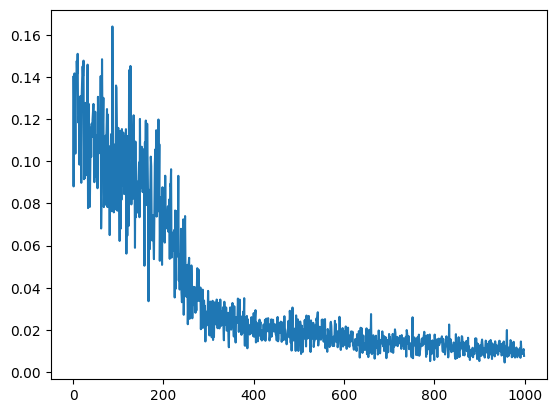

In [45]:
train(model,dataset,lr,batch_size,num_epochs,device)

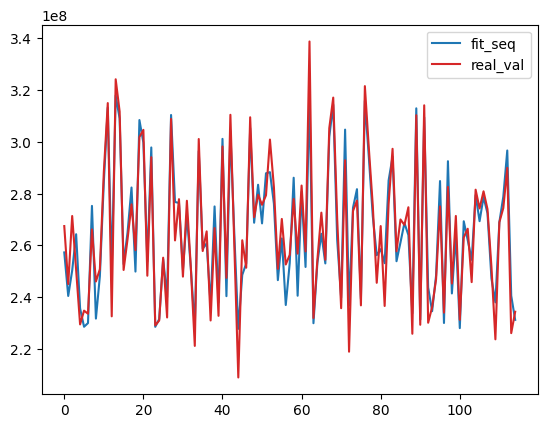

In [46]:
#real_mean
#real_std
sample_nums = len(input_series)-horizon_size-seq_len
data_iter = DataLoader(dataset=dataset, batch_size=sample_nums, shuffle=True,num_workers=0)
for (input_X,input_seasonal,input_real_vals) in data_iter:
    fit_seq = model.predict(input_X, input_seasonal)
    fit_seq = fit_seq * real_std.reshape(-1, 1) + real_mean.reshape(-1, 1)
    input_real_vals = input_real_vals * real_std.reshape(-1, 1) + real_mean.reshape(-1, 1)
    plt.plot(fit_seq,color = '#1f77b4',label='fit_seq')
    plt.plot(input_real_vals, color = '#d62728',label='real_val')
    plt.legend()

In [52]:
#测试集
dateparse = lambda dates:pd.datetime.strptime(dates,'%Y-%m-%d')
purchase_seq_test = pd.read_csv('./total_purchase_test.csv',parse_dates=['report_date'],index_col=['report_date'],date_parser=dateparse)
test_mean = np.mean(purchase_seq_test)
test_std = np.std(purchase_seq_test)
test_std = test_std.to_numpy()
test_mean = test_mean.to_numpy()
purchase_seq_test= (purchase_seq_test - np.mean(purchase_seq_test))/np.std(purchase_seq_test)
#测试集季节性分解
test_decomposition = seasonal_decompose(purchase_seq_test)
test_trend = test_decomposition.trend
test_seasonal = test_decomposition.seasonal
test_residual = test_decomposition.resid

test_trend = test_trend.fillna(0)
test_seasonal = test_seasonal.fillna(0)
test_residual = test_residual.fillna(0)

test_trend = torch.tensor(test_trend).unsqueeze(dim=1)
test_seasonal = torch.tensor(test_seasonal).unsqueeze(dim=1)
test_residual = torch.tensor(test_residual).unsqueeze(dim=1)
#测试集日历协变量
test_time_range = pd.date_range('2014-08-02','2014-08-31',freq='D')
test_covariate_df = pd.DataFrame(index=test_time_range,
                                 data={'dayofweek':test_time_range.dayofweek,
                                       'month': test_time_range.month
                                })
#日历数据（协变量）标准化
for col in test_covariate_df.columns:
    test_covariate_df[col] = (test_covariate_df[col] - np.mean(test_covariate_df[col]))/np.std(test_covariate_df[col])
#由于都是同一个月的，所以取值都是一样的，标准化的时候会出现nan，直接置为1就可以了
test_covariate_df = test_covariate_df.fillna(1.0)
test_covariate_df = torch.tensor(test_covariate_df.to_numpy())
test_input_series = torch.concat([test_trend,test_residual,test_covariate_df],dim=1)
#由于这个月份数据全都是一样的，归一化之后会变成nan所以需要处理

c:\ProgramData\Anaconda3\envs\pytorch_train\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


tensor([[[ 0.0000e+00,  0.0000e+00,  9.0116e-01,  1.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  1.3927e+00,  1.0000e+00],
         [ 0.0000e+00,  0.0000e+00, -1.5565e+00,  1.0000e+00],
         [ 2.3069e-01,  1.2460e+00, -1.0650e+00,  1.0000e+00],
         [ 1.6274e-01, -1.5706e-01, -5.7346e-01,  1.0000e+00],
         [ 3.6477e-01, -3.2413e-01, -8.1923e-02,  1.0000e+00],
         [ 3.6692e-01, -5.0841e-01,  4.0962e-01,  1.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00,  1.3927e+00,  1.0000e+00],
         [ 0.0000e+00,  0.0000e+00, -1.5565e+00,  1.0000e+00],
         [ 2.3069e-01,  1.2460e+00, -1.0650e+00,  1.0000e+00],
         [ 1.6274e-01, -1.5706e-01, -5.7346e-01,  1.0000e+00],
         [ 3.6477e-01, -3.2413e-01, -8.1923e-02,  1.0000e+00],
         [ 3.6692e-01, -5.0841e-01,  4.0962e-01,  1.0000e+00],
         [ 4.5660e-02, -3.2705e-01,  9.0116e-01,  1.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00, -1.5565e+00,  1.0000e+00],
         [ 2.3069e-01,  1.2460e+00, -1.0650e+00,  1

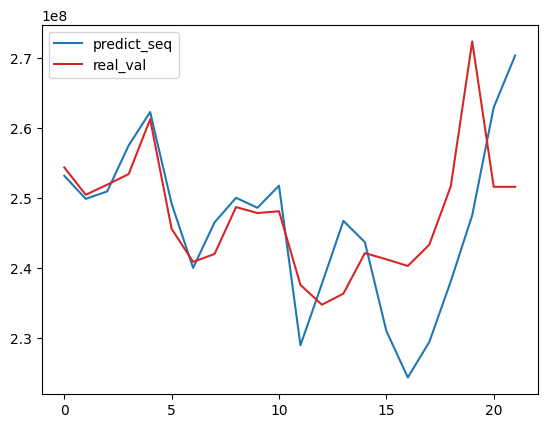

In [55]:
test_dataset = ARIMA_LSTM_dataset(test_input_series,test_seasonal,horizon_size,seq_len)
test_sample_nums = len(test_input_series)-horizon_size-seq_len
test_data_iter = DataLoader(dataset=test_dataset, batch_size=test_sample_nums, shuffle=False,num_workers=0)
for (test_input,test_input_seasonal,test_real_vals) in test_data_iter:
    print(test_input)
    test_seq = model.predict(test_input, test_input_seasonal)
    print(test_seq)
    test_seq = test_seq * test_std.reshape(-1, 1) + test_mean.reshape(-1, 1)
    test_real_vals = test_real_vals * test_std.reshape(-1, 1) + test_mean.reshape(-1, 1)
    plt.plot(test_seq,color = '#1f77b4',label='predict_seq')
    plt.plot(test_real_vals, color = '#d62728',label='real_val')
    plt.legend()

In [60]:
#可以看到，效果还是很不错的，预测误差最高的，也不到10%
#总误差0.0049
mape = (test_real_vals - test_seq)/test_real_vals
print(mape)
s_mape = (sum(test_real_vals) - sum(test_seq))/sum(test_real_vals)
print(s_mape)

tensor([[ 0.0047],
        [ 0.0023],
        [ 0.0038],
        [-0.0162],
        [-0.0039],
        [-0.0146],
        [ 0.0036],
        [-0.0187],
        [-0.0053],
        [-0.0030],
        [-0.0148],
        [ 0.0363],
        [-0.0128],
        [-0.0440],
        [-0.0064],
        [ 0.0424],
        [ 0.0663],
        [ 0.0571],
        [ 0.0539],
        [ 0.0911],
        [-0.0451],
        [-0.0746]], dtype=torch.float64)
tensor([0.0049], dtype=torch.float64)
